## Stock Price Analysis and Moving Average Crossover Strategy

In [6]:
#Necessary starting libraries
import pandas as pd
import numpy as np
import math

#Visualization
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('YOURLOGIN', 'YOURPASSWORD')

#Datetime tools
import datetime

# Package and modules for importing dataimport quandl
import quandl
quandl.ApiConfig.api_key = 'YOURAPI'
from pandas_datareader import data, wb  

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# magic to not to call show every time 
%matplotlib inline

#Setting default plot configurations
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.style.use('ggplot')

#### TimeFrame and Stock Inputs

In [7]:
start_date_input = input('Enter a starting date in YYYY-MM-DD format:')
year_s, month_s, day_s = map(int, start_date_input.split('-'))
start = datetime.date(year_s, month_s, day_s)

end_date_input = input('Enter an ending date in YYYY-MM-DD format: ')
year_e, month_e, day_e = map(int, end_date_input.split('-'))
end = datetime.date(year_e, month_e, day_e)

ticker_input = input("Enter a stock ticker for analysis: ")

Enter a starting date in YYYY-MM-DD format:2015-01-01
Enter an ending date in YYYY-MM-DD format: 2018-03-01
Enter a stock ticker for analysis: AAPL


#### Visual Exploratory Data Analysis

In [8]:
stock = quandl.get("WIKI/" + ticker_input, start_date=start, end_date=end)

round(stock.tail(3),3)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-02-27,179.10,180.480,178.16,178.39,38685165.0,0.0,1.0,179.10,180.480,178.16,178.39,38685165.0
2018-02-28,179.26,180.615,178.05,178.12,33604574.0,0.0,1.0,179.26,180.615,178.05,178.12,33604574.0
2018-03-01,178.54,179.775,172.66,175.00,48801970.0,0.0,1.0,178.54,179.775,172.66,175.00,48801970.0


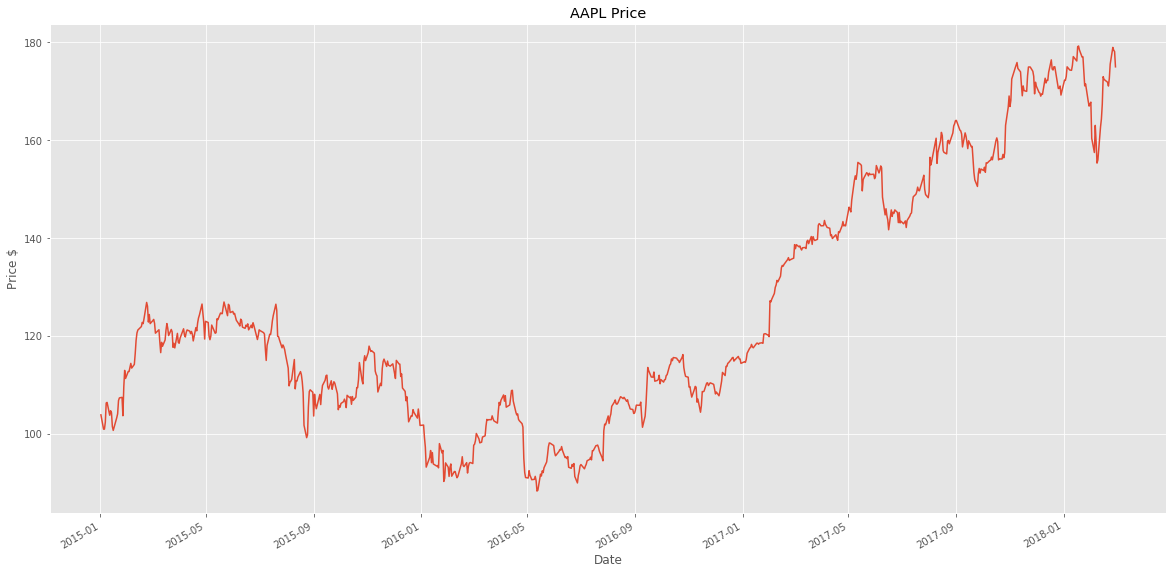

In [9]:
stock["Adj. Close"].plot(grid = True)
plt.title(str(ticker_input)+" Price")
plt.ylabel("Price $")
plt.show()

In [10]:
facebook, google, netflix, amazon = (quandl.get("WIKI/" + s, start_date=start, end_date=end) for s in ["FB", "GOOGL", "NFLX", "AMZN"])
 
stocks = pd.DataFrame({ticker_input: stock["Adj. Close"],
                      "FB": facebook["Adj. Close"],
                      "GOOGL": google["Adj. Close"],
                      "NFLX": netflix["Adj. Close"],
                      "AMZN": amazon["Adj. Close"]})

spyder = data.DataReader("SPY", "yahoo", start, end)
stocks = stocks.join(spyder.loc[:, "Adj Close"]).rename(columns={"Adj Close": "SPY"})
 
stocks.head()

,AAPL,FB,GOOGL,NFLX,AMZN,SPY
Date,,,,,,
2015-01-02,103.863957,78.450,529.55,49.848571,308.52,190.791763
2015-01-05,100.937944,77.190,519.46,47.311429,302.19,187.346115
2015-01-06,100.947444,76.150,506.64,46.501429,295.29,185.581497
2015-01-07,102.362951,76.150,505.15,46.742857,298.42,187.894058
2015-01-08,106.295968,78.175,506.91,47.779286,300.46,191.228256


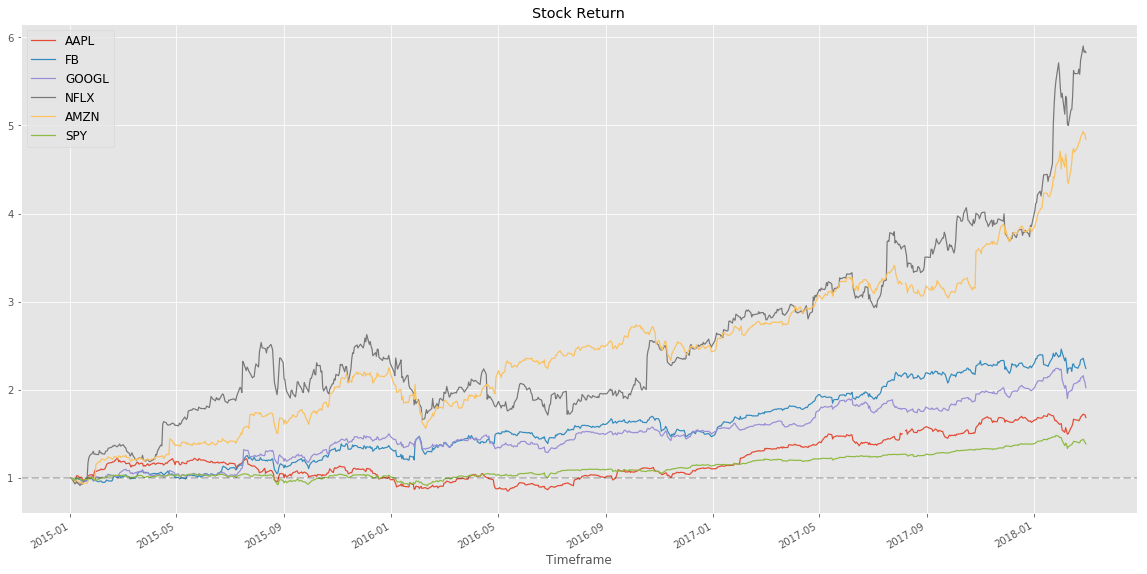

In [11]:
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.plot(lw=1.2 , grid = True).axhline(y = 1, color = "black", lw = 2, alpha=.2, linestyle='--')
plt.legend(loc='upper left', fontsize=12)
plt.xlabel('Timeframe')
plt.title("Stock Return")
plt.show()

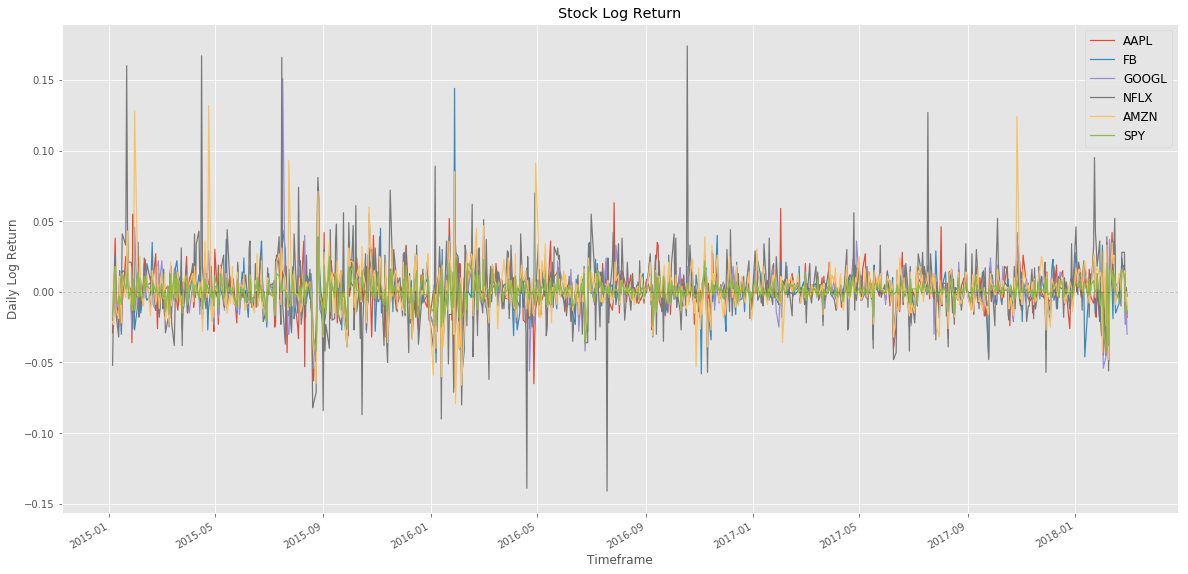

In [12]:
stock_log_change = round(stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))),3)
stock_log_change.plot(lw=1.2, grid=True).axhline(y = 0, color = "black", lw = 1, alpha=.2, linestyle='--')

plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Daily Log Return')
plt.xlabel('Timeframe')
plt.title("Stock Log Return")

plt.show()

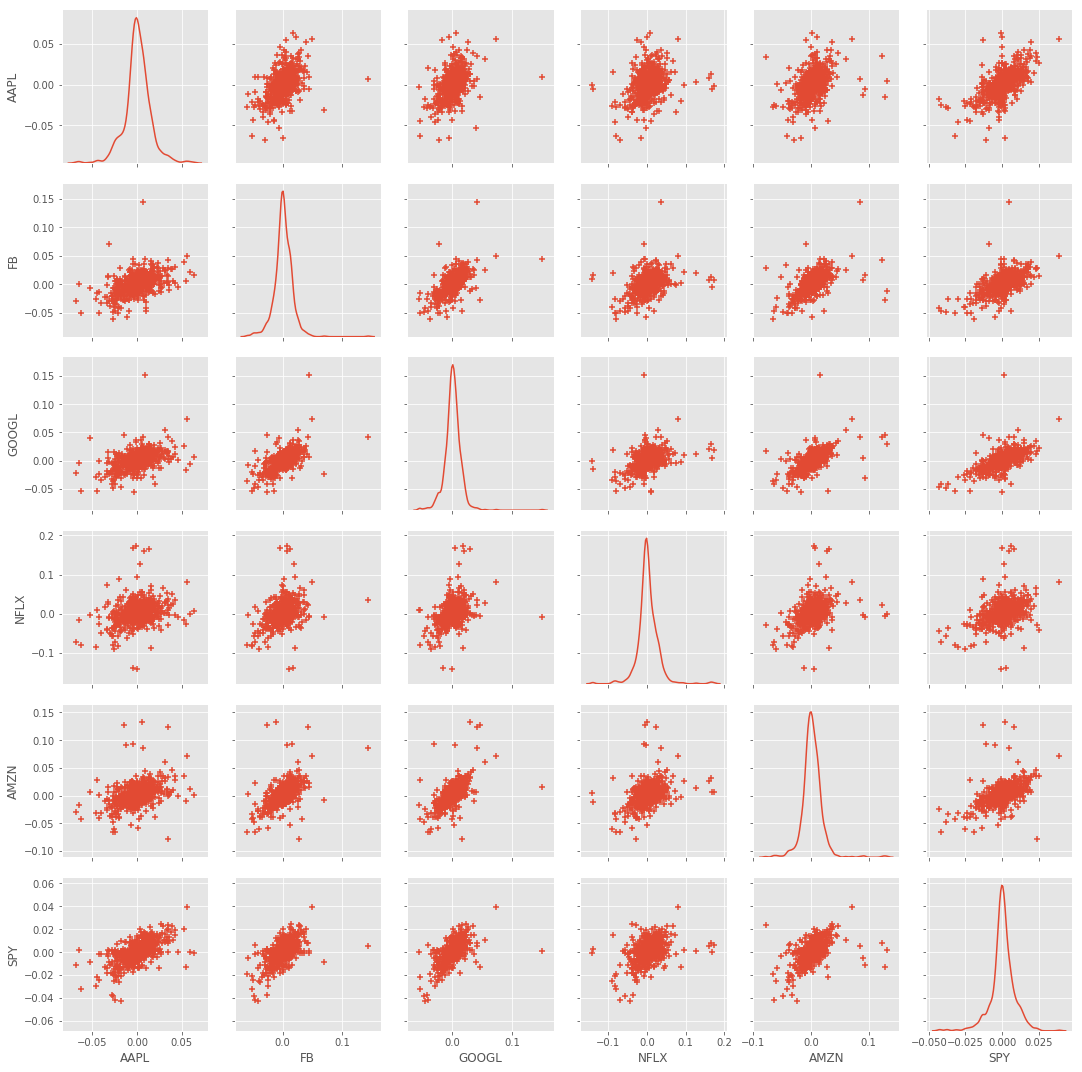

In [13]:
sn.pairplot(stock_log_change, palette='Set2', diag_kind='kde', markers = '+')
plt.show()

In [14]:
stock["14d"] = np.round(stock["Adj. Close"].rolling(window = 14, center = False).mean(), 3)
stock["40d"] = np.round(stock["Adj. Close"].rolling(window = 40, center = False).mean(), 3)
stock["200d"] = np.round(stock["Adj. Close"].rolling(window = 200, center = False).mean(), 3)

stock['14 Day STD'] = np.round(stock["Adj. Close"].rolling(window = 14, center = False).std(), 3)
stock['Upper Band'] = stock["14d"] + (stock['14 Day STD'] * 2)
stock['Lower Band'] = stock["14d"] - (stock['14 Day STD'] * 2)

In [15]:
#Candlestick chart with plotly
trace_1 = go.Candlestick(x=stock.index, open=stock.Open, name = 'CS', high=stock.High, low=stock.Low, 
                         close=stock.Close, increasing=dict(line=dict(color= '#17BECF')),
                       decreasing=dict(line=dict(color= '#7F7F7F')))

trace_2 = go.Scatter(
    x = stock.index,
    y = stock["14d"], name = '14d MA', mode = 'lines', line = dict(
        color = 'gold', width=1))

trace_3 = go.Scatter(
    x = stock.index,
    y = stock["40d"], name = '40d MA', mode = 'lines', line = dict(
        color = '#E377C2', width=1))

trace_4 = go.Scatter(
    x = stock.index, 
    y = stock["200d"], name = '200d MA', mode = 'lines', line = dict(
        color = ('rgb(22, 96, 167)'), shape='spline', width=1))

trace_5 = go.Scatter(
    x = stock.index, 
    y = stock['Upper Band'], legendgroup="Bollinger Bands", name = 'U-Band', mode = 'lines', line = dict(
        color = 'darkkhaki', shape='spline', width=.4))

trace_6 = go.Scatter(
    x = stock.index, 
    y = stock['Lower Band'],
  legendgroup="Bollinger Bands",name = 'L-Band',showlegend=True, mode = 'lines', line = dict(
        color = 'darkkhaki', shape='spline', width=.4))

data_plotly = [trace_1, trace_2, trace_3, trace_4, trace_5, trace_6]
layout = go.Layout(title=str(ticker_input+" CandleStciks with Moving Averages"),legend=dict(orientation="h"),
                   xaxis = dict(rangeslider = dict(visible = False)))


fig_plotly = go.Figure(data=data_plotly,layout=layout)
py.iplot(fig_plotly, filename='candlestick with MAs')

#### Moving Average Crossover Strategy Implementation

In [16]:
stock['14d-40d'] = stock['14d'] - stock['40d']
stock.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,14d,40d,200d,14 Day STD,Upper Band,Lower Band,14d-40d
Date,,,,,,,,,,,,,,,,,,,
2018-02-23,173.67,175.650,173.54,175.555,33329232.0,0.0,1.0,173.67,175.650,173.54,175.555,33329232.0,165.876,170.386,160.493,7.005,179.886,151.866,-4.510
2018-02-26,176.35,179.390,176.21,178.970,36886432.0,0.0,1.0,176.35,179.390,176.21,178.970,36886432.0,167.410,170.595,160.629,7.370,182.150,152.670,-3.185
2018-02-27,179.10,180.480,178.16,178.390,38685165.0,0.0,1.0,179.10,180.480,178.16,178.390,38685165.0,168.507,170.778,160.757,7.798,184.103,152.911,-2.271
2018-02-28,179.26,180.615,178.05,178.120,33604574.0,0.0,1.0,179.26,180.615,178.05,178.120,33604574.0,169.835,171.000,160.888,7.735,185.305,154.365,-1.165
2018-03-01,178.54,179.775,172.66,175.000,48801970.0,0.0,1.0,178.54,179.775,172.66,175.000,48801970.0,171.240,171.069,160.996,6.600,184.440,158.040,0.171


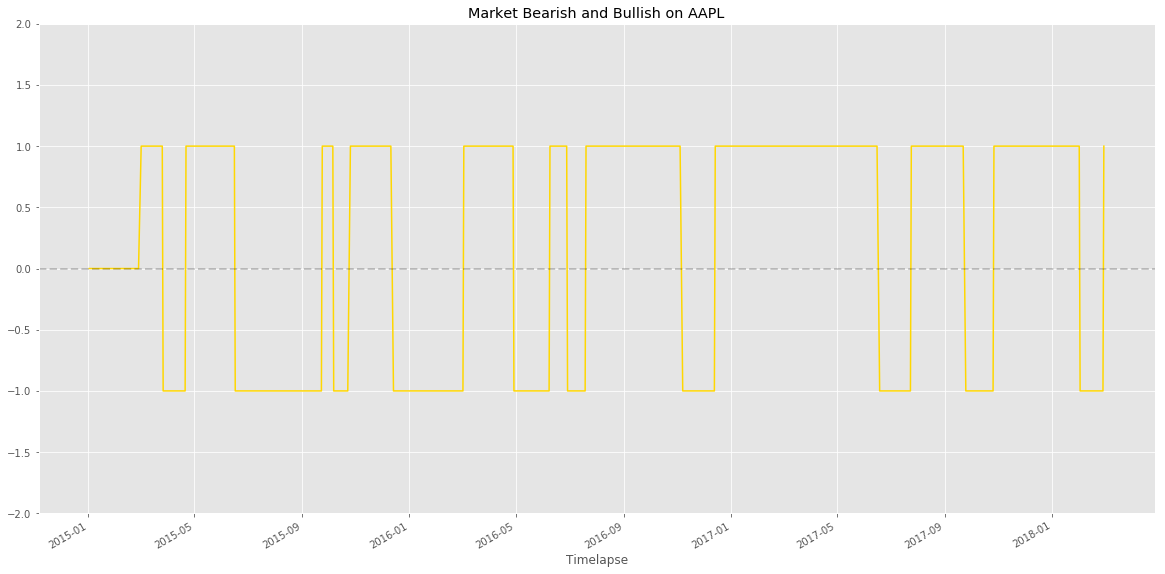

In [17]:
stock["Regime"] = np.where(stock['14d-40d'] > 0, 1, 0)
stock["Regime"] = np.where(stock['14d-40d'] < 0, -1, stock["Regime"])
stock["Regime"].plot(ylim = (-2,2), color='gold').axhline(y = 0, color = "black", lw = 2, alpha=.2, linestyle='--')

plt.xlabel("Timelapse")
plt.title("Market Bearish and Bullish on " + ticker_input)
plt.show()

In [18]:
print(stock["Regime"].value_counts())
print("_"*80)
print("The output indicates that for the given period the market was bearish on stock for " +  str(len(stock[stock['Regime'] == 1])) + " days, while for " + str(len(stock[stock['Regime'] == -1])) + " days the market was bullish, and it was neutral for " + str(len(stock[stock['Regime'] == 0])) + " days.")

 1    467
-1    288
 0     39
Name: Regime, dtype: int64
________________________________________________________________________________
The output indicates that for the given period the market was bearish on stock for 467 days, while for 288 days the market was bullish, and it was neutral for 39 days.


In [19]:
stock.loc[:, "Regime"].iloc[-1] = -1
stock["Signal"] = np.sign(stock["Regime"] - stock["Regime"].shift(1))
stock.tail(2)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,...,Adj. Volume,14d,40d,200d,14 Day STD,Upper Band,Lower Band,14d-40d,Regime,Signal
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-28,179.26,180.615,178.05,178.12,33604574.0,0.0,1.0,179.26,180.615,178.05,...,33604574.0,169.835,171.000,160.888,7.735,185.305,154.365,-1.165,-1,0.0
2018-03-01,178.54,179.775,172.66,175.00,48801970.0,0.0,1.0,178.54,179.775,172.66,...,48801970.0,171.240,171.069,160.996,6.600,184.440,158.040,0.171,-1,0.0


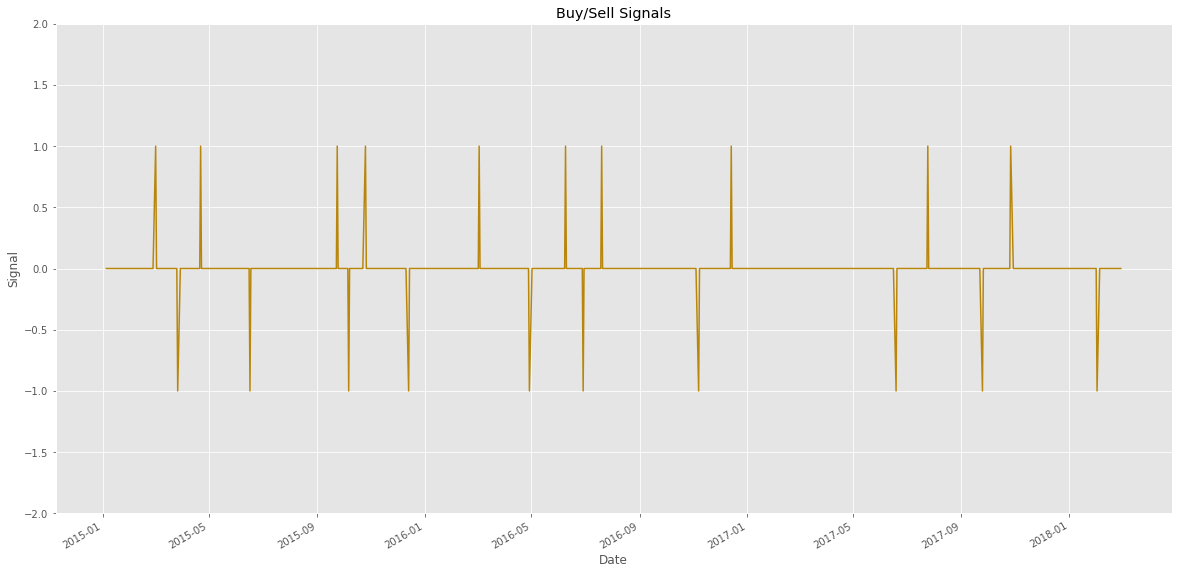

In [20]:
stock["Signal"].plot(ylim = (-2, 2), color = 'darkgoldenrod')

plt.title("Buy/Sell Signals")
plt.ylabel("Signal")
plt.show()

In [21]:
print("The strategy will buy the stock " + str(len(stock[stock['Signal'] == 1.0])) + " times, and sell the stock " + str(len(stock[stock['Signal'] == -1.0])) + " times.")

The strategy will buy the stock 10 times, and sell the stock 10 times.


In [22]:
stock_signals = pd.concat([
        pd.DataFrame({"Price": stock.loc[stock["Signal"] == 1, "Adj. Close"],
                     "Regime": stock.loc[stock["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": stock.loc[stock["Signal"] == -1, "Adj. Close"],
                     "Regime": stock.loc[stock["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
stock_signals.sort_index(inplace = True)
stock_signals.tail(3)

,Price,Regime,Signal
Date,,,
2017-09-25,150.55,-1,Sell
2017-10-27,163.05,1,Buy
2018-02-02,160.37,-1,Sell


In [23]:
stock_long_profits = pd.DataFrame({
        "Price": stock_signals.loc[(stock_signals["Signal"] == "Buy") &
                                  stock_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(stock_signals["Price"] - stock_signals["Price"].shift(1)).loc[
            stock_signals.loc[(stock_signals["Signal"].shift(1) == "Buy") & (stock_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": stock_signals["Price"].loc[
            stock_signals.loc[(stock_signals["Signal"].shift(1) == "Buy") & (stock_signals["Regime"].shift(1) == 1)].index
        ].index
    })
stock_long_profits

,Price,Profit,End Date
Date,,,
2015-03-02,123.116605,-5.569765,2015-03-27
2015-04-22,122.668353,-0.754905,2015-06-17
2015-09-24,110.631343,-4.059689,2015-10-07
2015-10-26,110.900706,-2.228303,2015-12-14
2016-03-03,98.591972,-7.537672,2016-04-29
2016-06-09,97.386708,-5.130760,2016-06-29
2016-07-20,97.689667,11.356608,2016-11-07
2016-12-14,113.767235,31.981397,2017-06-19
2017-07-25,152.122770,-1.572770,2017-09-25


In [24]:
tradeperiods = pd.DataFrame({"Start": stock_long_profits.index,
                            "End": stock_long_profits["End Date"]})
stock_long_profits["Low"] = tradeperiods.apply(lambda x: min(stock.loc[x["Start"]:x["End"], "Adj. Low"]), axis = 1)
stock_long_profits

,Price,Profit,End Date,Low
Date,,,,
2015-03-02,123.116605,-5.569765,2015-03-27,116.001802
2015-04-22,122.668353,-0.754905,2015-06-17,117.651750
2015-09-24,110.631343,-4.059689,2015-10-07,103.233473
2015-10-26,110.900706,-2.228303,2015-12-14,106.073464
2016-03-03,98.591972,-7.537672,2016-04-29,89.859540
2016-06-09,97.386708,-5.130760,2016-06-29,89.421814
2016-07-20,97.689667,11.356608,2016-11-07,94.230069
2016-12-14,113.767235,31.981397,2017-06-19,113.342546
2017-07-25,152.122770,-1.572770,2017-09-25,146.704753


#### Trading Strategy Inputs

In [25]:
portfolio_total_value = int(input("Enter Portfolio Total Value:"))
percentage_portfolio_trading = float(input("Enter the proportion of portfolio [0,1] to be included in trading: "))
stoploss = float(input("Enter the portfolio proportion [0,1] of trade loss that would trigger a stoploss: "))

Enter Portfolio Total Value:1000000
Enter the proportion of portfolio [0,1] to be included in trading: .1
Enter the portfolio proportion [0,1] of trade loss that would trigger a stoploss: .2


#### Strategy Backtesting

In [26]:
stock_backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})

batch = 100      # Number of shares bought per batch
for index, row in stock_long_profits.iterrows():
    batches = np.floor(portfolio_total_value * percentage_portfolio_trading) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        share_profit = np.round((1 - stoploss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    
    # Add a row to the backtest data frame containing the results of the trade
    stock_backtest = stock_backtest.append(pd.DataFrame({
                "Start Port. Value": portfolio_total_value,
                "End Port. Value": portfolio_total_value + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    portfolio_total_value = max(0, portfolio_total_value + profit)
 
stock_backtest

,Start Port. Value,End Port. Value,End Date,Shares,Share Price,Trade Value,Profit per Share,Total Profit,Stop-Loss Triggered
2015-03-02,1.000000e+06,9.955442e+05,2015-03-27,800.0,123.116605,98493.283722,-5.569765,-4455.812045,0.0
2015-04-22,9.955442e+05,9.949403e+05,2015-06-17,800.0,122.668353,98134.682410,-0.754905,-603.923685,0.0
2015-09-24,9.949403e+05,9.916925e+05,2015-10-07,800.0,110.631343,88505.074482,-4.059689,-3247.751429,0.0
2015-10-26,9.916925e+05,9.899099e+05,2015-12-14,800.0,110.900706,88720.565098,-2.228303,-1782.642329,0.0
2016-03-03,9.899099e+05,9.823722e+05,2016-04-29,1000.0,98.591972,98591.972196,-7.537672,-7537.671963,0.0
2016-06-09,9.823722e+05,9.772414e+05,2016-06-29,1000.0,97.386708,97386.708135,-5.130760,-5130.759837,0.0
2016-07-20,9.772414e+05,9.885980e+05,2016-11-07,1000.0,97.689667,97689.667288,11.356608,11356.607900,0.0
2016-12-14,9.885980e+05,1.014183e+06,2017-06-19,800.0,113.767235,91013.788163,31.981397,25585.117802,0.0
2017-07-25,1.014183e+06,1.013240e+06,2017-09-25,600.0,152.122770,91273.661835,-1.572770,-943.661835,0.0
2017-10-27,1.013240e+06,1.011632e+06,2018-02-02,600.0,163.050000,97830.000000,-2.680000,-1608.000000,0.0


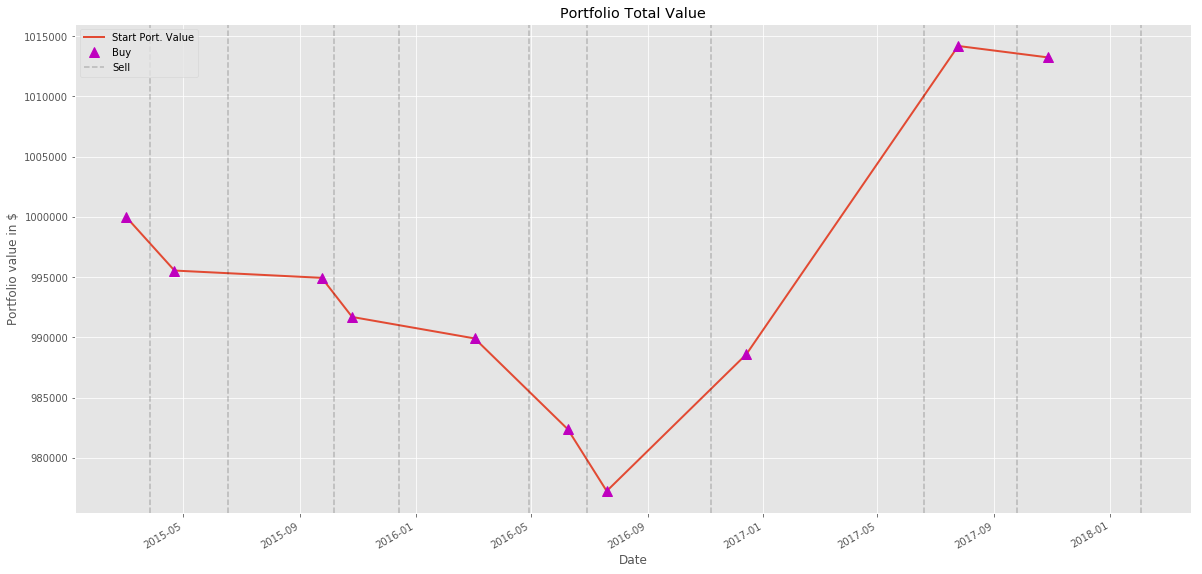

In [27]:
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')

# Plot the equity curve in dollars
ax = stock_backtest["Start Port. Value"].plot(ax=ax1, lw=2.)

ax1.plot(stock_backtest["Start Port. Value"][stock_backtest[stock_signals.Regime == 1].index],
         '^', markersize=10, color='m', label = "Buy")

sell_label = 'Sell'
for i in range(0,len(stock_backtest['End Date'])):
    ax1.axvline(stock_backtest['End Date'][i], color="black", linestyle = "--", alpha = .2, label=sell_label)
    sell_label = "_nolegend_"

plt.title("Portfolio Total Value")
plt.xlabel("Date")
plt.legend(loc='upper left')
plt.show()

In [29]:
Return_net = stock_backtest['Total Profit'].sum()
print("Net Return for the period is " + str(round(Return_net,2))+"\n")

return_perc = Return_net/(portfolio_total_value*percentage_portfolio_trading)
print("% Return for the period is "+ str(round(return_perc*100,2))+"\n")

av_annual_return = ((1+return_perc)**(1/((stock_backtest['End Date'][-1]-stock_backtest.index[0]).days/365.25))-1)
print("Average Annual Return is " + str(round(av_annual_return*100,2)))

Net Return for the period is 11631.5

% Return for the period is 11.5

Average Annual Return is 3.79


#### Benchmarking

In [30]:
batches = portfolio_total_value // np.ceil(100 * stocks.SPY.iloc[0]) # Maximum number of batches of stocks invested in
trade_val = batches * batch * stocks.SPY.iloc[0] # How much money is used to buy SPY
final_val = batches * batch * stocks.SPY.iloc[-1] + (portfolio_total_value - trade_val) # Final value of the portfolio
print("The Final Value for the S&P 500 Market Portfolio under buy & hold strategy over the same period is " + str(round(final_val,2)))

The Final Value for the S&P 500 Market Portfolio under buy & hold strategy over the same period is 1400928.62


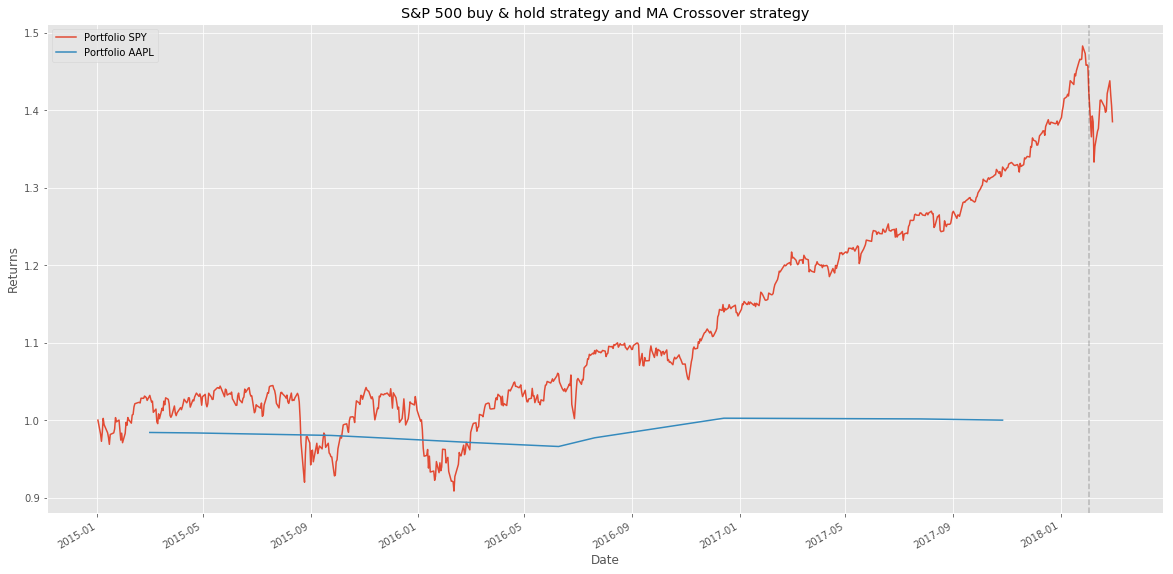

In [32]:
ax_bench = (stocks.SPY / stocks.SPY.iloc[0]).plot(label = "Portfolio SPY")
ax_bench = (stock_backtest["End Port. Value"].groupby(level = 0).apply(lambda x: x[-1]) / portfolio_total_value).plot(ax = ax_bench, label = ("Portfolio "+ticker_input))

plt.legend()
plt.title("S&P 500 buy & hold strategy and MA Crossover strategy")
plt.axvline(stock_backtest['End Date'][-1], color="black", linestyle = "--", alpha = .2)
plt.ylabel('Returns')
plt.show()